# Accuracy Assessment_AGDD
- This notebook is to do accuracy assessment for Accumulated Growing Degree Days (AGDD) data and interpolation model we choose
- Model
    - Inverse distance weighted (IDW)
    - Ordinary Kriging
    - Universal Kriging

#### Package

In [35]:
import arcpy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### Workspace

In [2]:
arcpy.env.workspace = r"D:\spring2024\GIS5572\Final\Final project GIS5572.gdb"

#### Interpolation algorithms results

In [3]:
# IDW
agdd_idw = "agdd_Idw"

# ORDINARY_KRIGING
agdd_uni_kri = "agdd_uni_kriging"

# UNIVERSAL_KRIGING
agdd_ord_kri = "agdd_ord_kriging"

### Accuracy Assessment

In [4]:
def differences_temp(true_points, interpolated_points):
    
    # get the name of interpolation method as part of the output point layer 
    interpolation = os.path.basename(interpolated_points)
    
    # spatal join
    output_join = f"diff_{interpolation}"
    arcpy.analysis.SpatialJoin(true_points, interpolated_points, output_join, "JOIN_ONE_TO_ONE", "KEEP_ALL", "", "CLOSEST")

    # rename column
    arcpy.management.AlterField(output_join, "Cumulative_GDD", "ground_truth", "ground_truth")
    arcpy.management.AlterField(output_join, "grid_code", "prediction", "prediction")

    # calculate difference
    fields = ["station", "ground_truth", "prediction", "residual"]
    arcpy.management.AddField(output_join, "residual", "DOUBLE")
    with arcpy.da.UpdateCursor(output_join, fields) as cursor:
        for row in cursor:
            row[3] = row[1] - row[2]  # "ground_truth" - "prediction"
            cursor.updateRow(row)
    arcpy.management.DeleteField(output_join,"Join_Count;max_tmpf;min_tmpf;name;X;Y;GDD;pointid;TARGET_FID;Station_ID;date","DELETE_FIELDS")
    
    print(f"Difference {interpolation} points layer created.")


In [11]:
true_points = "IEM_temp_data"

# ORDINARY_KRIGING
differences_temp(true_points, agdd_idw)
# UNIVERSAL_KRIGING
differences_temp(true_points, agdd_uni_kri)
# IDW
differences_temp(true_points, agdd_ord_kri)

Difference agdd_Idw points layer created.
Difference agdd_uni_kriging points layer created.
Difference agdd_ord_kriging points layer created.


### Defince the RMSE, MAE, R^2 function

In [5]:
# RMSE
def RMSE(data):
    residual_squared_sum = 0
    count = 0
    for row in arcpy.da.SearchCursor(data, ['residual']):
        residual_squared_sum += row[0] ** 2
        count += 1
            
    rmse = (residual_squared_sum / count) ** 0.5
    return rmse



In [6]:
# Mean Absolute Error
def MAE(data):
    absolute_errors = []
    with arcpy.da.SearchCursor(data, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth = row[0]
            prediction = row[1]
            absolute_errors.append(abs(ground_truth - prediction))
    
    
    mae = sum(absolute_errors) / len(absolute_errors)
    return mae


In [7]:
# Coefficient Of Determination
def R_squared(data):
    y_true = []
    y_pred = []
    
    with arcpy.da.SearchCursor(data, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            y_true.append(row[0])
            y_pred.append(row[1])
    
    y_mean = sum(y_true) / len(y_true)    
    ss_total = sum((y_i - y_mean) ** 2 for y_i in y_true)   
    ss_residual = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))   
    r_squared = 1 - (ss_residual / ss_total)   
    return r_squared


In [66]:
# AGDD 
diff_agdd_interpolation = [ "diff_agdd_Idw","diff_agdd_ord_kriging", "diff_agdd_uni_kriging"]

for diff_agdd in diff_agdd_interpolation:
    
    print(f"{diff_agdd} RMSE:", RMSE(diff_agdd))
    
    print(f"{diff_agdd} MAE:", MAE(diff_agdd))

    print(f"{diff_agdd} R^2:", R_squared(diff_agdd))

diff_agdd_Idw RMSE: 3.450527957103475
diff_agdd_Idw MAE: 1.2893155265730865
diff_agdd_Idw R^2: 0.9999219068571313
diff_agdd_ord_kriging RMSE: 60.501751780129325
diff_agdd_ord_kriging MAE: 34.426210439732095
diff_agdd_ord_kriging R^2: 0.9759907994485744
diff_agdd_uni_kriging RMSE: 218.94787160577133
diff_agdd_uni_kriging MAE: 169.6146516603421
diff_agdd_uni_kriging R^2: 0.6855705211377086


### Display Accuracy Assessment Results

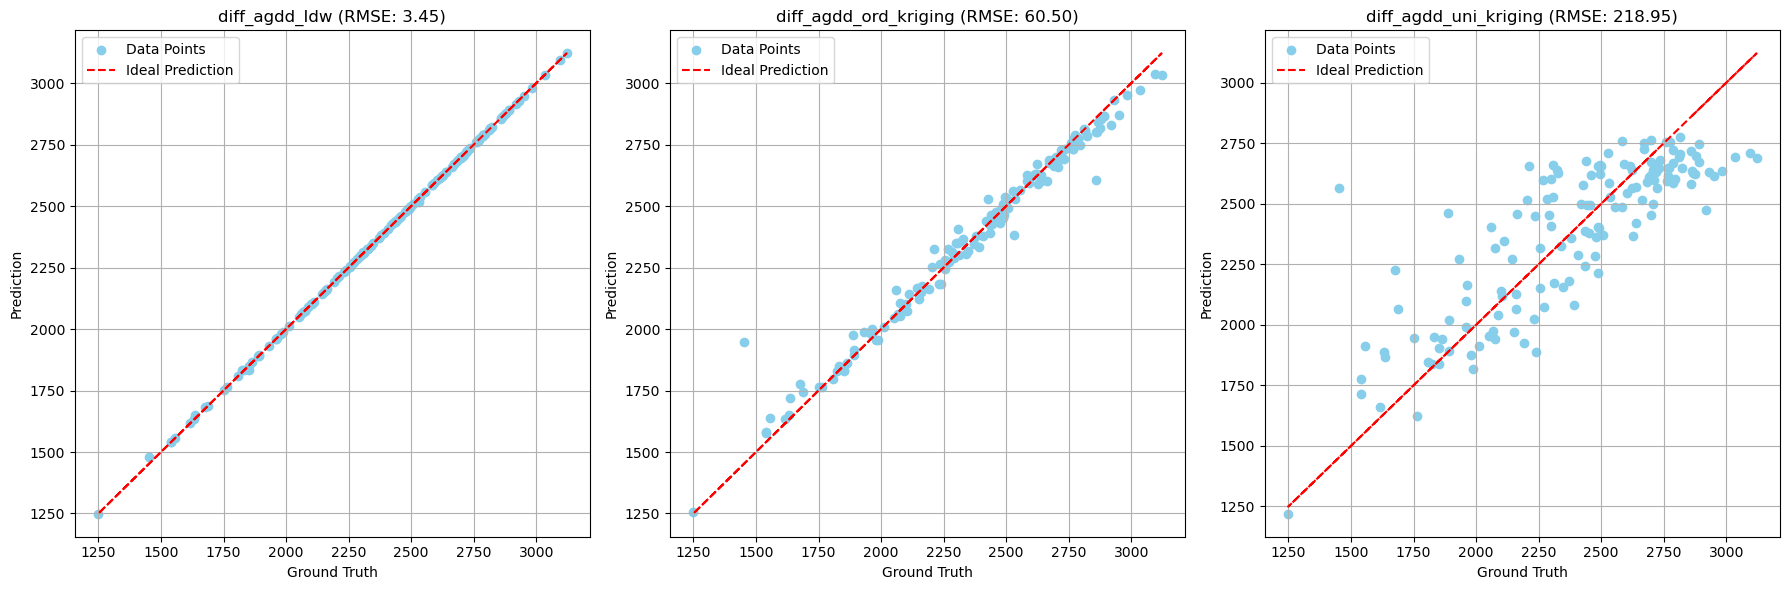

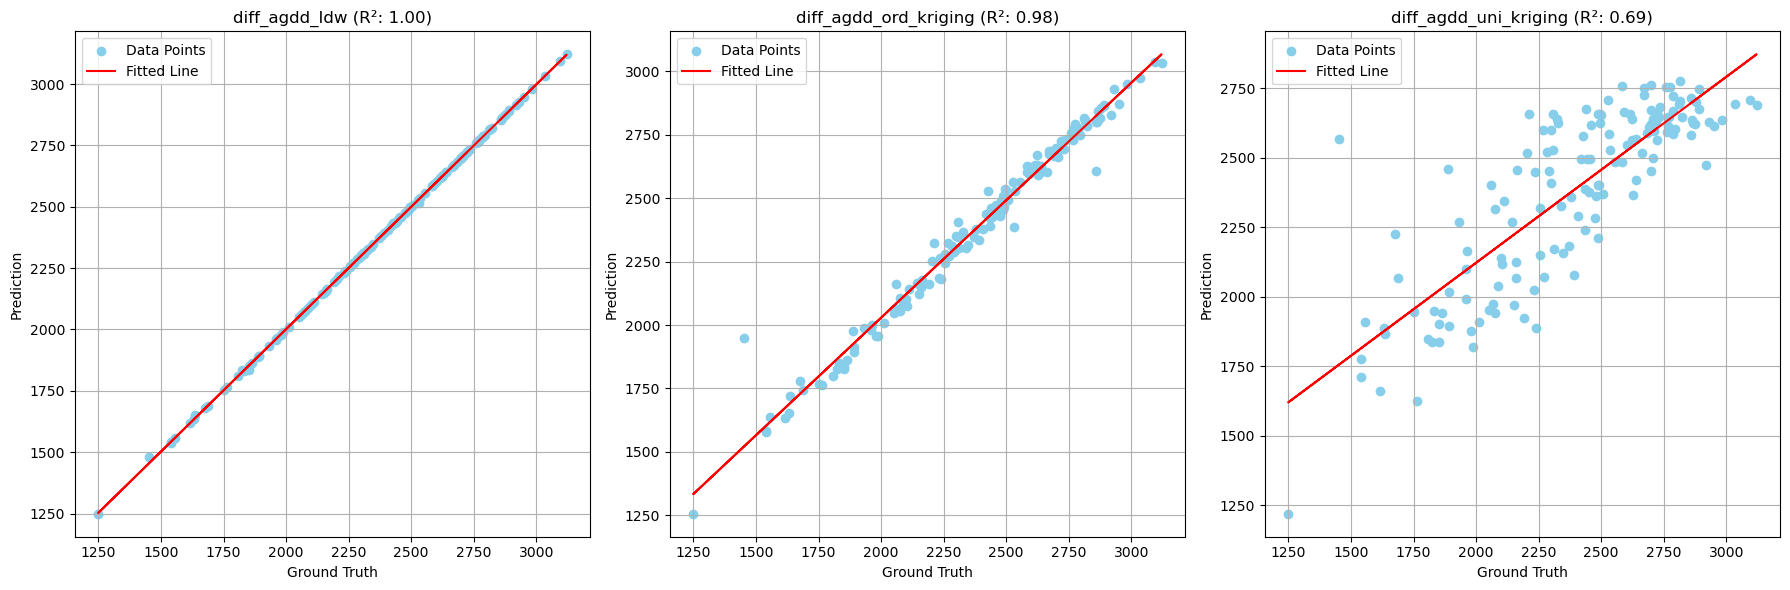

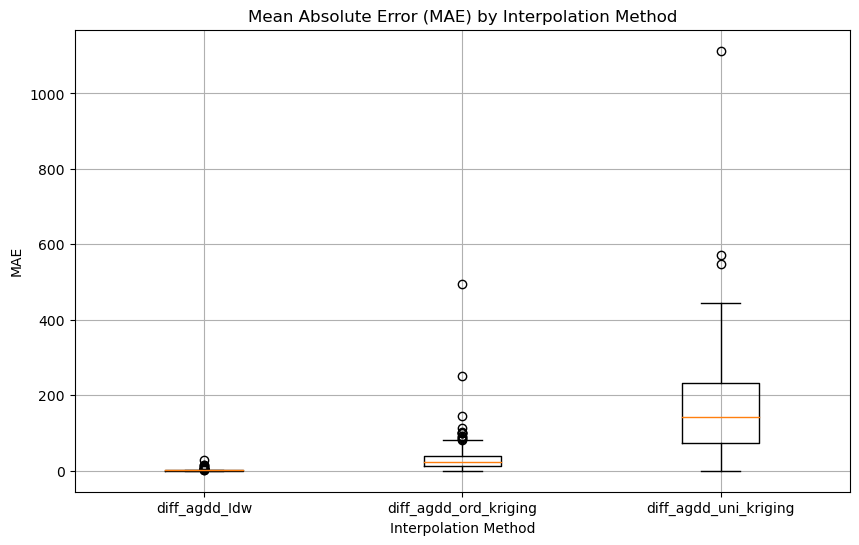

In [39]:
%matplotlib inline

# AGDD
diff_agdd_interpolation = ["diff_agdd_Idw", "diff_agdd_ord_kriging", "diff_agdd_uni_kriging"]

# creating scatter plots for RMSE
plt.figure(figsize=(18, 6))
for i, diff_agdd in enumerate(diff_agdd_interpolation, 1):
    # extracting data from "ground_truth" and "prediction" columns
    ground_truth_values = []
    prediction_values = []

    with arcpy.da.SearchCursor(diff_agdd, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth_values.append(row[0])
            prediction_values.append(row[1])

    # calculating RMSE
    rmse_value = RMSE(diff_agdd)

    # creating scatter plot in subplots
    plt.subplot(1, 3, i)
    plt.scatter(ground_truth_values, prediction_values, color='skyblue', label='Data Points')
    plt.plot(ground_truth_values, ground_truth_values, color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title(f'{diff_agdd} (RMSE: {rmse_value:.2f})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# creating scatter plots for R²
plt.figure(figsize=(18, 6))

for i, diff_agdd in enumerate(diff_agdd_interpolation):
    ground_truth_values = []
    prediction_values = []
    with arcpy.da.SearchCursor(diff_agdd, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth_values.append(row[0])
            prediction_values.append(row[1])
    
    # fit the data using LinearRegression
    model = LinearRegression()
    model.fit(np.array(ground_truth_values).reshape(-1, 1), prediction_values)
    
    # calculate R²
    r2 = R_squared(diff_agdd)
    
    # creating scatter plot in subplots
    plt.subplot(1, 3, i+1)
    plt.scatter(ground_truth_values, prediction_values, color='skyblue', label='Data Points')
    plt.plot(ground_truth_values, model.predict(np.array(ground_truth_values).reshape(-1, 1)), color='red', label='Fitted Line')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title(f'{diff_agdd} (R²: {r2:.2f})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# creating boxplots for MAE
mae_values = []
for diff_agdd in diff_agdd_interpolation:
    mae_values_diff_agdd = []
    with arcpy.da.SearchCursor(diff_agdd, ["ground_truth", "prediction"]) as cursor:
        for row in cursor:
            ground_truth = row[0]
            prediction = row[1]
            mae = abs(ground_truth - prediction)
            mae_values_diff_agdd.append(mae)
    
    mae_values.append(mae_values_diff_agdd)

plt.figure(figsize=(10, 6))
plt.boxplot(mae_values, labels=diff_agdd_interpolation)
plt.xlabel('Interpolation Method')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) by Interpolation Method')
plt.grid(True)
plt.show()
